# Capstone Project - Regression
### by Andrew Ebenbach

In [1]:
import numpy as np
import pandas as pd
import random
import os
import itertools 
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Set Seed and constants

In [2]:
SEED = 13195176

# Set the seed for numpy
np.random.seed(SEED)
# Set the seed for Python built-in random module
random.seed(SEED)

using_GPU = False

### Import and prepare data

In [3]:
import pandas as pd

def process_large_text_file(file_path):
    data = []
    review_counts = {}
    current_integer = None
    count = None
    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()
            if line.endswith(':'):
                review_counts[current_integer] = count
                
                count=0
                current_integer = int(line[:-1])
            else:
                count+=1
                values = line.split(',')
                assert len(values) == 3
                data.append([current_integer, int(values[0]), int(values[1]), values[2]])

        review_counts[current_integer] = count
            
    df = pd.DataFrame(data, columns=['movie_id', 'user_id', 'rating', 'date'])
    return df, review_counts

file_path = '/kaggle/input/capstone/data.txt'  # Replace with the path to your large text file
data, review_counts_dict = process_large_text_file(file_path)
print(data.head())


   movie_id  user_id  rating        date
0         1  1488844       3  2005-09-06
1         1   822109       5  2005-05-13
2         1   885013       4  2005-10-19
3         1    30878       4  2005-12-26
4         1   823519       3  2004-05-03


In [4]:
movies = pd.read_csv('/kaggle/input/capstone/movieTitles.csv', header=None)
movies.columns = ['movie_id', 'release_year','title','none1','none2']

movies = movies.drop(['none1','none2'],axis=1) # there are only 5 movies with info in these columns
data = pd.merge(data, movies, on='movie_id', how='left')
print(data.head())

   movie_id  user_id  rating        date  release_year            title
0         1  1488844       3  2005-09-06        2003.0  Dinosaur Planet
1         1   822109       5  2005-05-13        2003.0  Dinosaur Planet
2         1   885013       4  2005-10-19        2003.0  Dinosaur Planet
3         1    30878       4  2005-12-26        2003.0  Dinosaur Planet
4         1   823519       3  2004-05-03        2003.0  Dinosaur Planet


### pre-split engineering
(engineering across rows)

In [5]:
data['review_year'] = data['date'].str[:4].astype(int)
data['movie_age'] = (data['review_year'] - data['release_year']).fillna(1000)

drop_cols = ['title','date','review_year','release_year']
data = data.drop(drop_cols, axis =1) # need to drop unused to save memory
data.head()

,movie_id,user_id,rating,movie_age
0,1,1488844,3,2.0
1,1,822109,5,2.0
2,1,885013,4,2.0
3,1,30878,4,2.0
4,1,823519,3,1.0


### performing the split

In [6]:
random.seed(SEED)

lower_bound = 0 
test_indexes = []
val_indexes = []
for movie_id in range(1,5001,1):
    review_count = review_counts_dict[movie_id]
    upper_bound = lower_bound+review_count
    
    chosen_test_idx = random.randint(lower_bound,upper_bound-1)
    chosen_val_idx = random.randint(lower_bound,upper_bound-1)
    while  chosen_test_idx == chosen_val_idx:
        chosen_test_idx = random.randint(lower_bound,upper_bound-1)
        chosen_val_idx = random.randint(lower_bound,upper_bound-1)
    
    test_indexes += [chosen_test_idx]
    val_indexes+= [chosen_val_idx]
    lower_bound = upper_bound
    

test_set = data.loc[test_indexes,:]
train_set = data.drop(test_indexes)

val_set = data.loc[val_indexes,:]
train_set = train_set.drop(val_indexes)

del data
del review_counts_dict
del movies

print(len(train_set))
print(len(val_set))
print(len(test_set))

27000225
5000
5000


### Feature Engineering
(engineering across rows and columns)

In [7]:
class TransformFeature():
    def __init__(self, groupby_col, transform_col, feature='mean' ):
        self.groupby_col = groupby_col
        self.transform_col = transform_col
        self.feature = feature
    
    def fit_transform(self, df_org):
        df = df_org.copy()
        if type(self.groupby_col) == list:
            col_name = f'{self.feature}_{"_".join(self.groupby_col)}_{self.transform_col}'
        else:
            col_name = f'{self.feature}_{self.groupby_col}_{self.transform_col}'
            
        df[col_name] = train_set.groupby(self.groupby_col)[self.transform_col].transform(self.feature)
        if type(self.groupby_col) == list:
            self.uniques = df[[*self.groupby_col,col_name]].groupby(self.groupby_col)[col_name].mean()
        else:
            self.uniques = df[[self.groupby_col,col_name]].groupby(self.groupby_col)[col_name].mean()
        return df
    def transform(self, df_org):
        df = df_org.copy()
        merged_df = pd.merge(df, self.uniques, on=self.groupby_col, how='left')
        return merged_df

# Primary transforms
# Typical rating for the movie
mean_movie = TransformFeature(groupby_col='movie_id', 
                                  transform_col='rating', feature='mean')
# Typical rating by the user
mean_user = TransformFeature(groupby_col='user_id', 
                                  transform_col='rating', feature='mean')
# Popularity of the movie
count_review = TransformFeature(groupby_col='movie_id', 
                                  transform_col='rating', feature='count')
# User Activeness
count_review_user = TransformFeature(groupby_col='user_id', 
                                  transform_col='rating', feature='count')

# Controversialness of the movie
rating_std = TransformFeature(groupby_col='movie_id', 
                                  transform_col='rating', feature='std')
# Extremity of the user
rating_std_user = TransformFeature(groupby_col='user_id', 
                                  transform_col='rating', feature='std')


train_set = mean_movie.fit_transform(train_set).fillna(3) #Nans are filled with my prior expectations
train_set = mean_user.fit_transform(train_set).fillna(3)
train_set = count_review.fit_transform(train_set).fillna(0)
train_set = rating_std.fit_transform(train_set).fillna(1)
train_set = count_review_user.fit_transform(train_set).fillna(0)
train_set = rating_std_user.fit_transform(train_set).fillna(1)

val_set = mean_movie.transform(val_set).fillna(3) 
val_set = mean_user.transform(val_set).fillna(3)
val_set = count_review.transform(val_set).fillna(0)
val_set = rating_std.transform(val_set).fillna(1)
val_set = count_review_user.transform(val_set).fillna(0)
val_set = rating_std_user.transform(val_set).fillna(1)

test_set = mean_movie.transform(test_set).fillna(3)
test_set = mean_user.transform(test_set).fillna(3)
test_set = count_review.transform(test_set).fillna(0)
test_set = rating_std.transform(test_set).fillna(1)
test_set = count_review_user.transform(test_set).fillna(0)
test_set = rating_std_user.transform(test_set).fillna(1)

print('Done with primary transforms.')
# Secondary transforms

train_set["disagreement"] = abs(train_set['rating'] - train_set['mean_movie_id_rating'])

# Group think vs contrarian
rating_std = TransformFeature(groupby_col='user_id', 
                                  transform_col='disagreement', feature='mean')

train_set = rating_std.fit_transform(train_set).fillna(1)

val_set = rating_std.transform(val_set).fillna(1)

test_set = rating_std.transform(test_set).fillna(1)

print('Done with secondary transforms.')

train_set

Done with primary transforms.
Done with secondary transforms.


,movie_id,user_id,rating,movie_age,mean_movie_id_rating,mean_user_id_rating,count_movie_id_rating,std_movie_id_rating,count_user_id_rating,std_user_id_rating,disagreement,mean_user_id_disagreement
0,1,1488844,3,2.0,3.750459,3.253333,545,1.069344,600,0.820738,0.750459,0.677371
1,1,822109,5,2.0,3.750459,4.024390,545,1.069344,41,0.821213,1.249541,0.775371
2,1,885013,4,2.0,3.750459,3.905263,545,1.069344,95,0.990097,0.249541,0.692751
3,1,30878,4,2.0,3.750459,3.638177,545,1.069344,351,0.819492,0.249541,0.583848
4,1,823519,3,1.0,3.750459,3.898305,545,1.069344,177,0.839946,0.750459,0.681124
...,...,...,...,...,...,...,...,...,...,...,...,...
27010220,5000,2415316,3,10.0,3.131461,3.309524,890,1.148981,42,0.896826,0.131461,0.777769
27010221,5000,1619362,3,11.0,3.131461,3.236025,890,1.148981,322,0.701716,0.131461,0.515803
27010222,5000,453585,4,11.0,3.131461,3.463320,890,1.148981,518,0.942037,0.868539,0.754012
27010223,5000,477466,3,11.0,3.131461,3.355372,890,1.148981,363,1.162438,0.131461,0.932881


In [8]:
val_set

,movie_id,user_id,rating,movie_age,mean_movie_id_rating,mean_user_id_rating,count_movie_id_rating,std_movie_id_rating,count_user_id_rating,std_user_id_rating,mean_user_id_disagreement
0,1,1008986,4,1.0,3.750459,3.684524,545.0,1.069344,168.0,0.666925,0.539624
1,2,1636093,5,1.0,3.552448,3.879518,143.0,1.281935,166.0,0.711764,0.614867
2,3,1924500,2,6.0,3.641791,3.597865,2010.0,0.977112,281.0,1.101231,0.812541
3,4,722591,4,10.0,2.714286,4.475113,140.0,1.293513,1105.0,0.659082,1.020698
4,5,799442,4,1.0,3.919156,3.311005,1138.0,1.293568,418.0,1.160469,0.964772
...,...,...,...,...,...,...,...,...,...,...,...
4995,4996,1903321,1,5.0,3.475175,3.347826,151845.0,1.116356,23.0,1.640640,1.216173
4996,4997,1460449,2,0.0,2.341317,3.172932,167.0,1.068568,133.0,1.215501,0.863237
4997,4998,2208519,3,55.0,3.117500,2.966825,400.0,1.027781,422.0,1.017117,0.880833
4998,4999,582792,3,2.0,2.918182,2.703704,440.0,1.022586,162.0,1.020832,0.952684


### Measuring User Similairity
First, we need to downsample

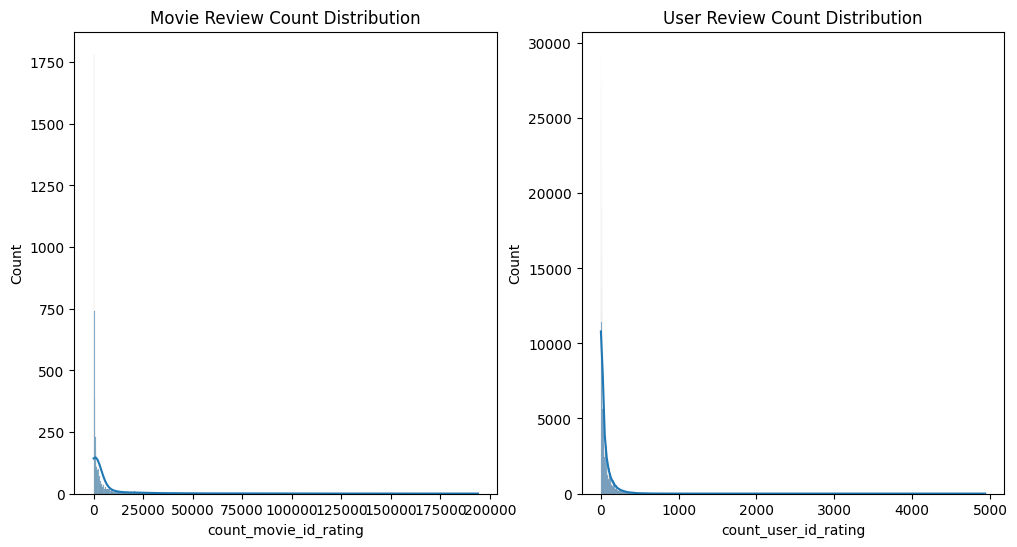

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot the histograms
sns.histplot(count_review.uniques, ax=ax[0], kde=True)
sns.histplot(count_review_user.uniques, ax=ax[1], kde=True)

# Set plot titles
ax[0].set_title('Movie Review Count Distribution')
ax[1].set_title('User Review Count Distribution')

# Display the plot
plt.show()

In [10]:
threshold_count = 6250
print(f'Proportion of movies left at {threshold_count} count threshold: {np.mean(count_review.uniques> threshold_count)}')
threshold_count_user = 0# unused feature

Proportion of movies left at 6250 count threshold: 0.1502


In [11]:
super_users = count_review_user.uniques> threshold_count_user
super_movies = count_review.uniques > threshold_count

super_movie_ids = super_movies[super_movies].index
super_user_ids = super_users[super_users].index

# Filter the dataframe using the isin() function
filtered_df = train_set[(train_set['movie_id'].isin(super_movie_ids)) & (train_set['user_id'].isin(super_user_ids))]

print('Reviews remaining:', len(filtered_df))
len(filtered_df['user_id'].unique())

Reviews remaining: 22844255


469562

In [12]:
# Create viewing history records for each user
pivot_table = filtered_df.pivot_table(index='user_id', columns='movie_id', values='rating', fill_value=0)


print(pivot_table.head())

movie_id  8     17    18    28    30    33    44    46    58    77    ...  \
user_id                                                               ...   
6            0     0     0     0     3     0     0     0     0     0  ...   
7            5     0     0     4     5     0     0     0     0     0  ...   
8            0     0     0     0     0     0     0     0     0     0  ...   
10           0     0     0     0     0     0     0     0     0     0  ...   
25           0     0     0     0     0     0     0     0     0     0  ...   

movie_id  4931  4932  4949  4951  4956  4972  4977  4978  4995  4996  
user_id                                                               
6            3     0     0     0     0     0     0     0     0     3  
7            3     4     0     4     0     3     3     0     0     3  
8            0     0     0     0     0     0     0     0     0     4  
10           0     0     2     0     0     0     0     0     0     0  
25           0     0     0     0  

16


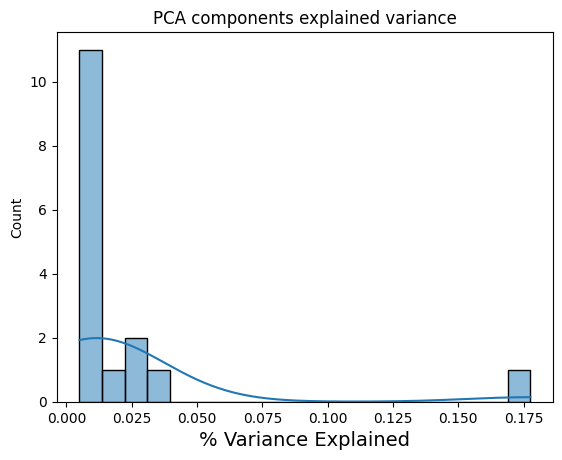

In [13]:
from sklearn.decomposition import PCA

pca = PCA()

pca.fit(pivot_table)

pca_results = pca.explained_variance_ratio_
over_2 = len(pca_results[pca_results > .005])
print(over_2)


ax = sns.histplot(pca_results[:over_2],  kde=True)
ax.set_xlabel('% Variance Explained', fontsize=14)

# Set plot titles
ax.set_title('PCA components explained variance')

# Display the plot
plt.show()

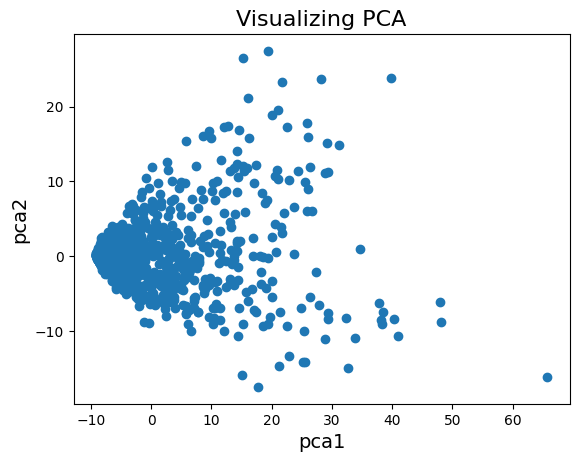

In [14]:
pca = PCA(over_2)

pca_users = pca.fit_transform(pivot_table)

plt.scatter(pca_users[:1000,0], pca_users[:1000,1])
# Set labels for axes
plt.xlabel('pca1', fontsize=14)
plt.ylabel('pca2', fontsize=14)

# Set the title
plt.title('Visualizing PCA', fontsize=16)

# Display the plot
plt.show()

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


45533707.27667945


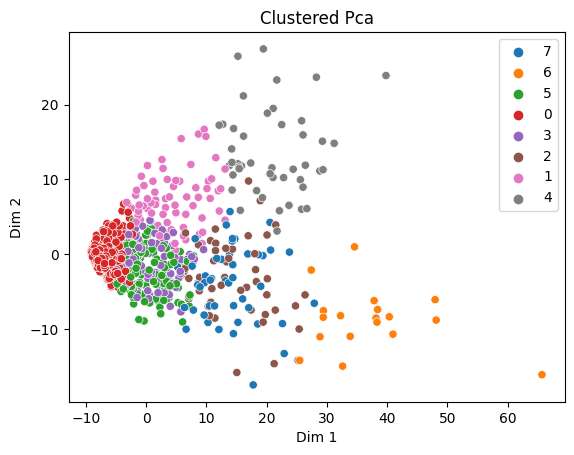

In [15]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=8, random_state=SEED)

labels_pca = kmeans.fit_predict(pca_users)
print(kmeans.inertia_)

# create scatter plot using seaborn
sns.scatterplot(x=pca_users[:1000,0],y= pca_users[:1000,1], hue=labels_pca[:1000].astype(str))

# add title and axis labels
plt.title(f"Clustered Pca")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")

# display plot
plt.show()

In [16]:
user_cluster = pd.Series(labels_pca, index = pivot_table.index)

del pivot_table
del pca_users
del filtered_df

train_set['user_cluster'] = train_set['user_id'].map(user_cluster).fillna(99)

val_set['user_cluster'] = val_set['user_id'].map(user_cluster).fillna(99)

test_set['user_cluster'] = test_set['user_id'].map(user_cluster).fillna(99)

# What similar users rated the movie
similar_user = TransformFeature(groupby_col=['user_cluster','movie_id'], 
                                  transform_col='rating', feature='mean')
# How man similar users rated the movie
similar_user_count = TransformFeature(groupby_col=['user_cluster','movie_id'], 
                                  transform_col='rating', feature='count')



train_set = similar_user.fit_transform(train_set).fillna(3)
train_set = similar_user_count.fit_transform(train_set).fillna(0)

val_set = similar_user.transform(val_set).fillna(3)
val_set = similar_user_count.transform(val_set).fillna(0)

test_set = similar_user.transform(test_set).fillna(3)
test_set = similar_user_count.transform(test_set).fillna(0)

train_set.head()

,movie_id,user_id,rating,movie_age,mean_movie_id_rating,mean_user_id_rating,count_movie_id_rating,std_movie_id_rating,count_user_id_rating,std_user_id_rating,disagreement,mean_user_id_disagreement,user_cluster,mean_user_cluster_movie_id_rating,count_user_cluster_movie_id_rating
0,1,1488844,3,2.0,3.750459,3.253333,545,1.069344,600,0.820738,0.750459,0.677371,6.0,3.714286,126
1,1,822109,5,2.0,3.750459,4.024390,545,1.069344,41,0.821213,1.249541,0.775371,5.0,4.000000,46
2,1,885013,4,2.0,3.750459,3.905263,545,1.069344,95,0.990097,0.249541,0.692751,0.0,3.880000,125
3,1,30878,4,2.0,3.750459,3.638177,545,1.069344,351,0.819492,0.249541,0.583848,6.0,3.714286,126
4,1,823519,3,1.0,3.750459,3.898305,545,1.069344,177,0.839946,0.750459,0.681124,7.0,3.824561,57


### Baseline

In [17]:
from sklearn.metrics import mean_squared_error

mean_squared_error(val_set.rating, val_set.mean_movie_id_rating, squared=False)

1.113883190394858

### Initial Model

In [18]:
predictors = ['mean_movie_id_rating','mean_user_id_rating','movie_age','count_user_id_rating',
              'count_movie_id_rating','std_movie_id_rating','std_user_id_rating','mean_user_id_disagreement',
             'user_cluster',"mean_user_cluster_movie_id_rating", "count_user_cluster_movie_id_rating"]
target = 'rating'

In [19]:

# define the RandomForestRegressor hyperparameters as a dictionary
rfr_params = {'n_estimators': 100,
              'max_depth': 5,
              'n_jobs' : -1
             }

# construct the RandomForestRegressor regressor model using the defined hyperparameters
model = RandomForestRegressor(**rfr_params)

X_train  =  train_set[predictors]
y_train = train_set[target]

X_val = val_set[predictors]
y_val = val_set[target]

model.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, n_jobs=-1)

In [20]:
val_preds = model.predict(X_val)

rmse_all = mean_squared_error(y_val, val_preds, squared=False)
print(rmse_all)

1.0039620367451791


### Finding the most important features

In [21]:

col_names = X_val.columns.tolist()
rmse_shuffles = []

# loop through each predictor
for col in col_names:
    # shuffle the values in the column
    X_shuffled = X_val.copy()
    X_shuffled[col] = np.random.permutation(X_shuffled[col])
    

    y_pred = model.predict(X_shuffled)

    rmse_shuffle = mean_squared_error(y_val, y_pred, squared=False)
    rmse_shuffles.append(rmse_shuffle)

# calculate the difference between the RMSE with all predictors and each predictor shuffle
rmse_diffs = [ rmse_all-  rmse_shuffle for rmse_shuffle in rmse_shuffles]

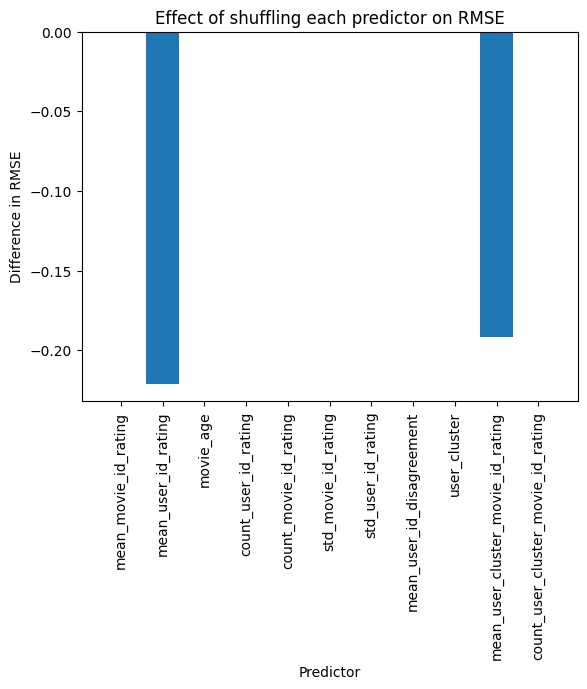

In [22]:
# create a bar chart to show the differences
fig, ax = plt.subplots()
ax.bar(col_names, rmse_diffs)
ax.set_xlabel('Predictor')
ax.set_ylabel('Difference in RMSE')
ax.set_title('Effect of shuffling each predictor on RMSE')
plt.xticks(rotation=90)
plt.show()

In [23]:
# Filter any useless predictors
filtered_predictors = [col_names[j] for j, diff in enumerate(rmse_diffs) if diff < 0]

X_train  =  train_set[filtered_predictors]
y_train = train_set[target]

X_val = val_set[filtered_predictors]
y_val = val_set[target]

print("Dropped: ", len(predictors) - len(filtered_predictors))
print("Remaining Predictors: ", filtered_predictors)

Dropped:  8
Remaining Predictors:  ['mean_user_id_rating', 'count_movie_id_rating', 'mean_user_cluster_movie_id_rating']


### Finding the best Hyperparams

In [24]:
n_estimators = [10,50, 100]
depths = [1,3,5]

best_model=None
best_rmse = 1000
for estimator_count in n_estimators:
    rfr_params['n_estimators'] = estimator_count
    for depth in depths:
        rfr_params['max_depth'] = depth
        model = RandomForestRegressor(**rfr_params)
        model.fit(X_train, y_train)
        val_preds = model.predict(X_val)
        rmse = mean_squared_error(y_val, val_preds, squared=False)
        print("Max Depth: ",depth,"N Estimators: " ,estimator_count,"Val RMSE: " ,rmse)
        
        if rmse < best_rmse:
            best_model = model
            best_rmse = rmse
        else:
            del model
        

Max Depth:  1 N Estimators:  10 Val RMSE:  1.1744290315929344
Max Depth:  3 N Estimators:  10 Val RMSE:  1.0638591109634483
Max Depth:  5 N Estimators:  10 Val RMSE:  1.0044381664886652
Max Depth:  1 N Estimators:  50 Val RMSE:  1.1692898025319358
Max Depth:  3 N Estimators:  50 Val RMSE:  1.0641152904833193
Max Depth:  5 N Estimators:  50 Val RMSE:  1.0039567159486404
Max Depth:  1 N Estimators:  100 Val RMSE:  1.1734878821388584
Max Depth:  3 N Estimators:  100 Val RMSE:  1.0641398385999064
Max Depth:  5 N Estimators:  100 Val RMSE:  1.0037301620529095


### Final Results

In [25]:
X_test = test_set[filtered_predictors]
y_test = test_set[target]

test_preds = best_model.predict(X_test)

rmse_test = mean_squared_error(y_test, test_preds, squared=False)
print("Final RMSE: ",rmse_test)

Final RMSE:  1.0129159568792057


### EC:

Understanding the clusters

In [26]:
# load movies back in
movies = pd.read_csv('/kaggle/input/capstone/movieTitles.csv', header=None)
movies.columns = ['movie_id', 'release_year','title','none1','none2']

movies = movies.drop(['none1','none2'],axis=1)

In [27]:


unique_clusters = train_set.user_cluster.unique()
results = []

# Collect info about each cluster

for i, cluster in enumerate(unique_clusters):
    cluster_records = train_set.loc[train_set.user_cluster == cluster]
    top_3_movies = cluster_records['movie_id'].value_counts()[:3].index.values
    movies_names = [movies.loc[movies.movie_id == movie_id, 'title'].values[0] for movie_id in top_3_movies]
    avg_review_count = cluster_records.count_user_id_rating.mean()
    avg_review_count_movie = cluster_records.count_movie_id_rating.mean()
    avg_user_rating = cluster_records.mean_user_id_rating.mean()

    results.append({
        'Cluster': cluster,
        'Top Movie 1': movies_names[0],
        'Top Movie 2': movies_names[1],
        'Top Movie 3': movies_names[2],
        'Average Review Count': avg_review_count,
        'Average Review Count per Movie': avg_review_count_movie,
        'Average User Rating': avg_user_rating
    })

results_df = pd.DataFrame(results)
results_df.set_index('Cluster', inplace=True)
display(results_df.sort_values(by="Cluster"))

    

,Top Movie 1,Top Movie 2,Top Movie 3,Average Review Count,Average Review Count per Movie,Average User Rating
Cluster,,,,,,
0.0,Gone in 60 Seconds,What Women Want,The Wedding Planner,24.622804,62097.228741,3.591293
1.0,American Beauty,Being John Malkovich,Pirates of the Caribbean: The Curse of the Bla...,106.401336,54970.103202,3.582122
2.0,Pirates of the Caribbean: The Curse of the Bla...,What Women Want,Erin Brockovich,158.463017,56517.301854,3.640403
3.0,Pirates of the Caribbean: The Curse of the Bla...,Man on Fire,The Bourne Supremacy,62.911289,69791.729144,3.603279
4.0,American Beauty,The Silence of the Lambs,The Sixth Sense,293.766760,40995.825050,3.443346
5.0,What Women Want,Pirates of the Caribbean: The Curse of the Bla...,Gone in 60 Seconds,61.079301,67488.465907,3.675819
6.0,Pirates of the Caribbean: The Curse of the Bla...,Speed,The Sixth Sense,439.237346,37667.369289,3.583555
7.0,Pirates of the Caribbean: The Curse of the Bla...,Bruce Almighty,Lord of the Rings: The Fellowship of the Ring,151.493884,57395.626090,3.651269
99.0,Empire Falls,His Secret Life,The Battle of Algiers,5.505129,1709.061989,3.715624
